## **Real or Not? NLP with Disaster Tweets <br>**
Kaggle ID: 5124789<br>
Kaggle Name: tizdag<br>
Kaggle Score: 0.84492 <br>
Leaderboard position: 95 (The first 66 notebooks achieved an unrealistically high score, which is due to leaked solutions.) <br>
Predict which Tweets are about real disasters and which ones are not
![alt text](https://miro.medium.com/max/1400/0*z9jqZsQ7JSTZGSZz.jpg)<br>
This notebook was created without cooperation partners.

In [ ]:
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install python-Levenshtein==0.12.0

     |████████████████████████████████| 40 kB 951 kB/s eta 0:00:01
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.5-py3-none-any.whl size=30314 sha256=895c75fa7bd9d0e2c5f14f4d8aed362ca26a74e1d5e0f185b4ad7b45521c7de4
  Stored in directory: /root/.cache/pip/wheels/b2/59/55/26a1acfa05bd61bc2da49333c3a8c0ba01465ad34471991459
  Created wheel for py-params: filename=py_params-0.9.7-py3-none-any.whl size=7302 sha256=fdc44b53dd8fae0b3dabbeb7f74dbffec0ce0530059a0d30efd0535ac8c26e16
  Stored in directory: /root/.cache/pip/wheels/47/3d/2d/bbffcfd6b9f4b8b5cbf07e7520ac2676192fe9431240c13ee8
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=6ccb57bf0a692f4f3c516c9cf0149a50828c928f10ea4bdce15a5ca660a38949
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
# import necessary libaries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
import re
from gensim.models import Word2Vec, KeyedVectors
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, Average, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import bert
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# load all necessary data from kaggle
train = pd.read_csv('../input/nlp-getting-started/train.csv', index_col='id')
test = pd.read_csv('../input/nlp-getting-started/test.csv', index_col='id')
sub_sample = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

Take a first look at the data and the structure

In [ ]:
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
sub_sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
# In order to get an overview how big the dataset is, we use shape
print(train.shape)
print(test.shape)
print(sub_sample.shape)

(7613, 4)
(3263, 3)
(3263, 2)


In [ ]:
train.info()
#we can get displayed, which columns are part of the data and the corresponding data type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


Check how many values are missing

In [ ]:
#missing values are really important for the models, so we need to know which data is missing
#as we can see, the location is missing in almost 1/3 of the tweets, so it's hard to base the model on this column, 
#it'll just be an additional information
train.isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
test.isnull().sum()

keyword       26
location    1105
text           0
dtype: int64

In [ ]:
#with the percentage, we get a better impression of how much data is proportionally missing
print("Percentage of keywords missing in train data:", (len(train[train['keyword'].isnull()==True])/train.shape[0])*100,"%")
print("Percentage of keywords missing in test data:", (len(test[test['keyword'].isnull()==True])/test.shape[0])*100,"%")
print("Percentage of location missing in train data:", (len(train[train['location'].isnull()==True])/train.shape[0])*100,"%")
print("Percentage of location missing in test data:", (len(test[test['location'].isnull()==True])/test.shape[0])*100,"%")

Percentage of keywords missing in train data: 0.8012610009194797 %
Percentage of keywords missing in test data: 0.796812749003984 %
Percentage of location missing in train data: 33.27203467752528 %
Percentage of location missing in test data: 33.86454183266932 %


In [ ]:
#replace NaN values with no_keyword/no_location
print("Replacing NaN values with no_keyword and no_location")
train["keyword"] = train["keyword"].fillna('no_keyword')
train["location"] = train["location"].fillna('no_location')
test["keyword"] = test["keyword"].fillna('no_keyword')
test["location"] = test["location"].fillna('no_location')

Replacing NaN values with no_keyword and no_location


In [ ]:
# remove complete duplicates, keep only the first occurence
print(train.shape)
train.drop_duplicates(keep='first', inplace=True)
print(train.shape)
# check other duplicates
train.drop_duplicates('text', keep=False, inplace=True)
print(train.shape)

(7613, 4)
(7561, 4)
(7455, 4)


Check if there are still duplicates in train or test data

In [ ]:
#Duplicates would falsify the result more quickly with a relatively small data set. This must also be taken into account with regard to overfitting.
print("Duplicate in train: " + str(train.duplicated().sum()))
print("Duplicate in test: " + str(test.duplicated().sum()))

Duplicate in train: 0
Duplicate in test: 11


Check whether a similar number of examples exist for classifications "1" and "0



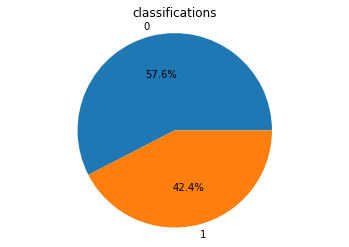

In [ ]:
#The distribution within the classification may also affect the final result.
target0 = train['target'].value_counts()[0]
target1 = train['target'].value_counts()[1]
labels = '0', '1'
sizes = [target0, target1]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')
ax.set_title("classifications")

plt.show()
#as about 57,6% of the data is classified as no disaster, 42,4% are real disasters - not a perfect distribution, but the dataset should be big enough

Check the number of unique keywords and if they are similar for train and test set

In [ ]:
print ("Train: " + str(train.keyword.nunique()))
print ("Test: " + str(test.keyword.nunique()))
#as the number of used keywords is similar, we can take a closer look at the used keywords

Train: 222
Test: 222


Show the most used keywords in both dataset

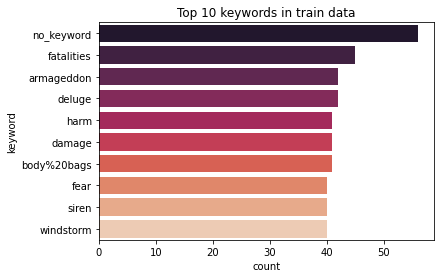

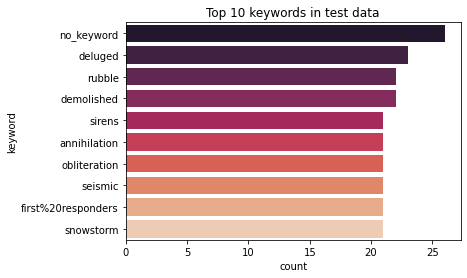

In [ ]:
plt.figure()
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:10].index, palette="rocket")
plt.title('Top 10 keywords in train data')
plt.show()

plt.figure()
sns.countplot(y=test.keyword, order = test.keyword.value_counts().iloc[:10].index, palette="rocket")
plt.title('Top 10 keywords in test data')
plt.show()

Compare most used keywords in train data for disaster tweets and non-disaster tweets

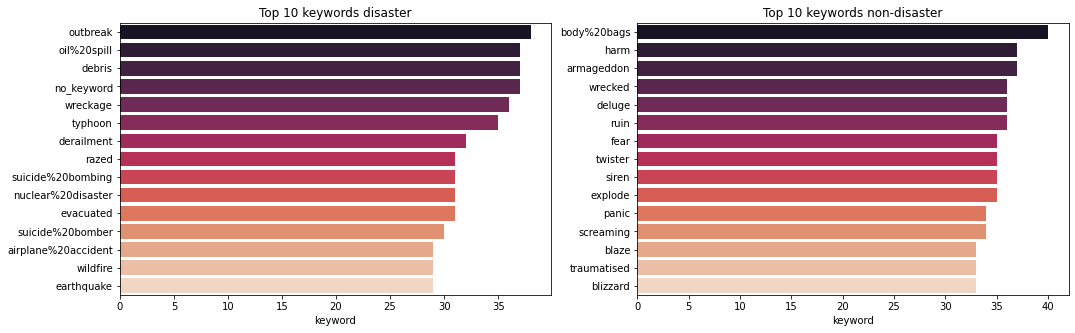

In [ ]:
disaster = train[train.target==1].keyword.value_counts().head(15)
nodisaster = train[train.target==0].keyword.value_counts().head(15)

plt.figure(figsize=(17,5))
plt.subplot(121)
sns.barplot(disaster, disaster.index, palette="rocket")
plt.title('Top 10 keywords disaster')
plt.subplot(122)
sns.barplot(nodisaster, nodisaster.index, palette="rocket")
plt.title('Top 10 keywords non-disaster')
plt.show()


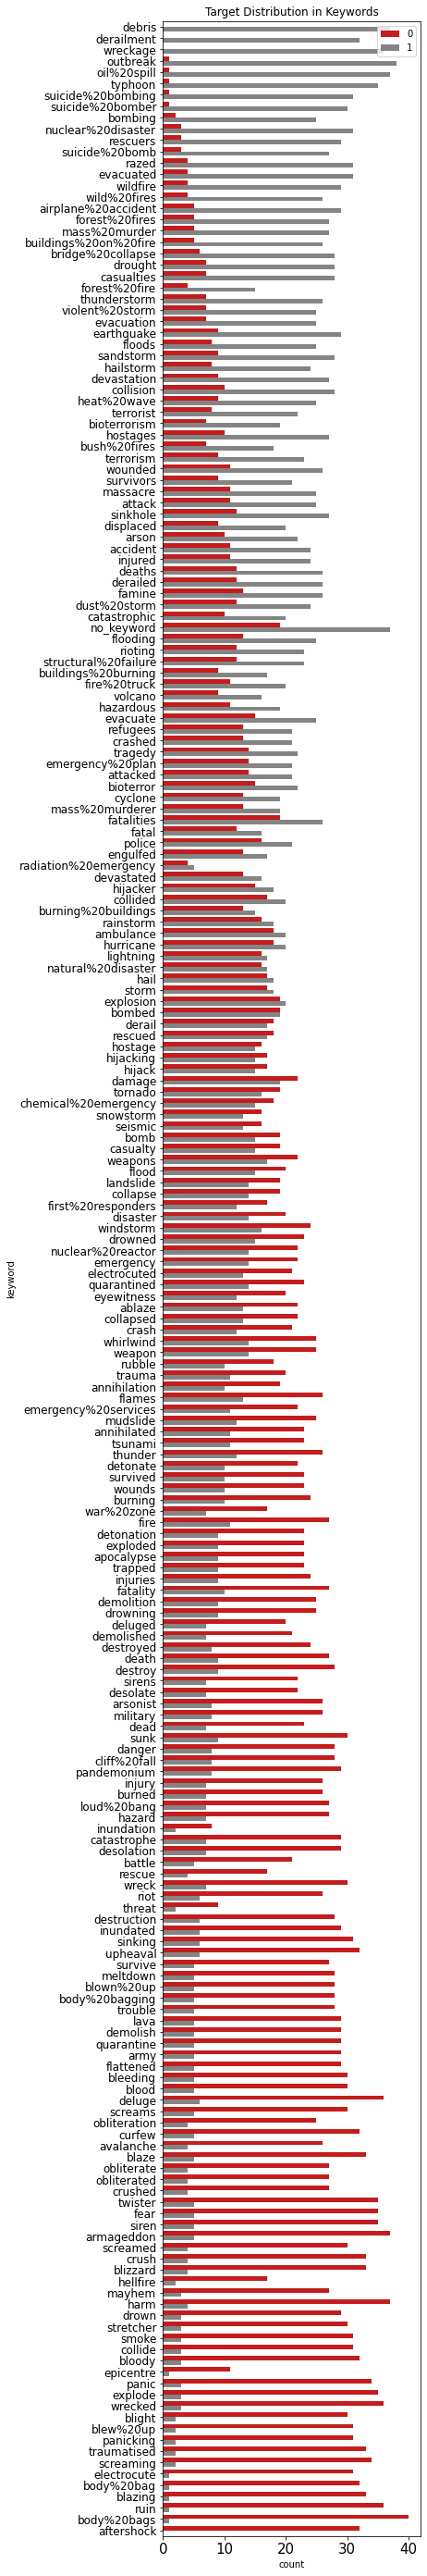

In [ ]:
#Since there is no overlap in the above graphic, a look at the assignment of keywords to the respective class might be a good approach.
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(5, 50))

sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending=False)['target'],palette=["#df0101", "#848484"])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

Show the most used locations

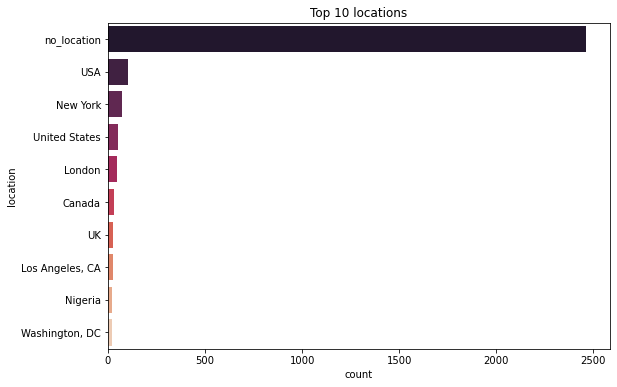

In [ ]:
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:10].index, palette="rocket")
plt.title('Top 10 locations')
plt.show()
#It can be seen that the locations are obviously not generated automatically, as no clear pattern can be identified. 
#Some of the data are countries and some cities within the countries already mentioned.

As locations are obviously not generated automatically, they shouldn't allways be used as a keyfeature in following steps.
Much more important seems to be the influence of single keywords on the final classification of the tweet

Additional information, which could be useful for following steps: <br>


`word_count` number of words in text <br>
`char_count` number of characters in text <br>
`unique_word_count` number of unique words in text <br>
`url_count` number of urls in text <br>
`mean_word_length` average character count in words <br>
`punctuation_count` number of punctuations in text <br>
`hashtag_count` number of hashtags # in text <br>
`mention_count` number of mentions @ in text <br>

In [ ]:
# word_count (method found at: https://www.geeksforgeeks.org/python-program-to-count-words-in-a-sentence/)
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
test['word_count'] = test['text'].apply(lambda x: len(str(x).split()))

#char_count
train['char_count'] = train['text'].apply(lambda x: len(x))
test['char_count'] = test['text'].apply(lambda x: len(x))

# unique_word_count (method found at: https://stackoverflow.com/questions/33726361/counting-the-number-of-unique-words-in-a-list)
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# link_count 
train['link_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['link_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# punctuation_count (method found at https://stackoverflow.com/questions/6969268/counting-letters-numbers-and-punctuation-in-a-string)
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# at_count
train['at_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['at_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

#stopword_count (method found at https://www.geeksforgeeks.org/removing-stop-words-nltk-python/)
train['stopword_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))
test['stopword_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))

# keyword target mean
train['keyword_target_mean'] = train.groupby('keyword')['target'].transform('mean')
test['keyword_target_mean'] = test['keyword'].apply(lambda x: train.loc[train['keyword'] == x, 'keyword_target_mean'].iloc[0])

In [ ]:
train=train.drop(columns='target_mean')

In [ ]:
#we will use all additional information in order to improve the result or our model
train_add_input = StandardScaler().fit_transform(train.iloc[:, 4:])
test_add_input = StandardScaler().fit_transform(test.iloc[:, 3:])

ADD_DIM = train_add_input.shape[1]
print(ADD_DIM)

10


In [ ]:
train.sort_values(by='keyword_target_mean', ascending=True).head(10)
#test.sort_values(by='keyword_target_mean', ascending=False).head(10)

,keyword,location,text,target,word_count,char_count,unique_word_count,link_count,mean_word_length,punctuation_count,hashtag_count,at_count,stopword_count,keyword_target_mean
id,,,,,,,,,,,,,,
178,aftershock,United States,&gt;&gt; $15 Aftershock : Protect Yourself and...,0,16,130,16,1,7.187500,17,2,1,4,0.0
146,aftershock,Instagram - @heyimginog,@afterShock_DeLo scuf ps live and the game... cya,0,8,49,8,0,5.250000,5,0,1,2,0.0
149,aftershock,304,'The man who can drive himself further once th...,0,20,110,17,0,4.500000,3,0,0,10,0.0
151,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...,0,16,138,14,2,7.687500,25,6,1,0,0.0
153,aftershock,304,'There is no victory at bargain basement price...,0,11,73,11,0,5.727273,3,0,0,3,0.0
156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,16,138,14,2,7.687500,25,6,1,0,0.0
158,aftershock,Instagram - @heyimginog,@afterShock_DeLo im speaking from someone that...,0,24,125,23,0,4.250000,3,0,1,12,0.0
159,aftershock,304,'The harder the conflict the more glorious the...,0,11,69,9,0,5.363636,3,0,0,4,0.0
160,aftershock,no_location,#GrowingUpSpoiled going clay pigeon shooting a...,0,11,83,11,0,6.636364,3,1,0,4,0.0


In [ ]:
#With the additional information, the correlation of the values with regard to the classification is examined more closely
train.corr()['target'].sort_values().drop('target')

at_count              -0.102412
stopword_count        -0.097858
word_count             0.040815
unique_word_count      0.054301
hashtag_count          0.059976
punctuation_count      0.133970
mean_word_length       0.175888
char_count             0.181686
link_count             0.202532
keyword_target_mean    0.545172
Name: target, dtype: float64

Check out if all columns are added correctly

In [ ]:
train.head()

,keyword,location,text,target,word_count,char_count,unique_word_count,link_count,mean_word_length,punctuation_count,hashtag_count,at_count,stopword_count,keyword_target_mean
id,,,,,,,,,,,,,,
1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,69,13,0,4.384615,1,1,0,6,0.660714
4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,38,7,0,4.571429,1,0,0,0,0.660714
5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,133,20,0,5.090909,3,0,0,11,0.660714
6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,65,8,0,7.125000,2,1,0,1,0.660714
7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,88,15,0,4.500000,2,2,0,7,0.660714


In [ ]:
test.head()

,keyword,location,text,word_count,char_count,unique_word_count,link_count,mean_word_length,punctuation_count,hashtag_count,at_count,stopword_count,keyword_target_mean
id,,,,,,,,,,,,,
0,no_keyword,no_location,Just happened a terrible car crash,6,34,6,0,4.833333,0,0,0,2,0.660714
2,no_keyword,no_location,"Heard about #earthquake is different cities, s...",9,64,9,0,6.222222,3,1,0,2,0.660714
3,no_keyword,no_location,"there is a forest fire at spot pond, geese are...",19,96,19,0,4.105263,2,0,0,9,0.660714
9,no_keyword,no_location,Apocalypse lighting. #Spokane #wildfires,4,40,4,0,9.250000,3,2,0,0,0.660714
11,no_keyword,no_location,Typhoon Soudelor kills 28 in China and Taiwan,8,45,8,0,4.750000,0,0,0,2,0.660714


Now take a closer look at the impact of word_count, char_count, unique_word_count, 
link_count, mean_word_length, punctuation_count, hashtag_count and @_count on the target

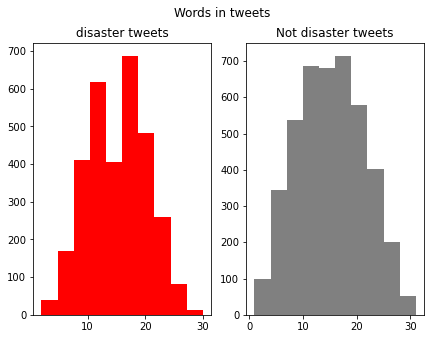

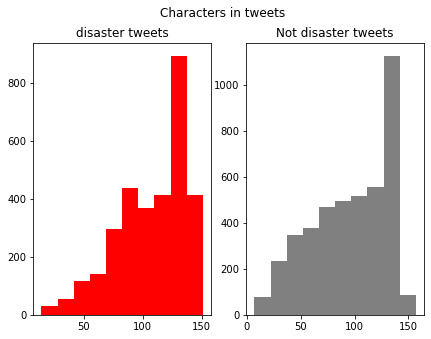

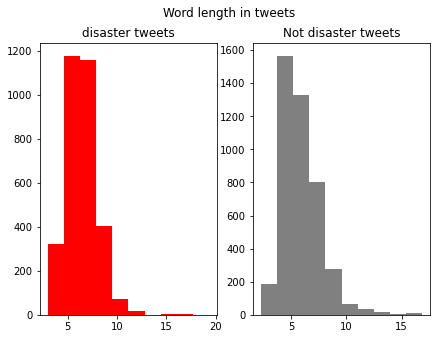

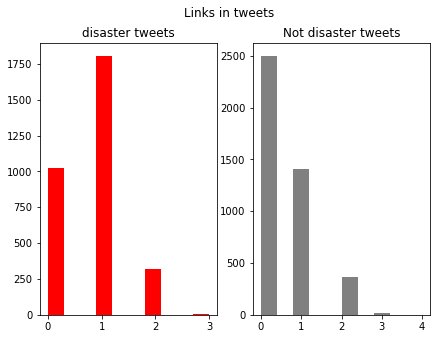

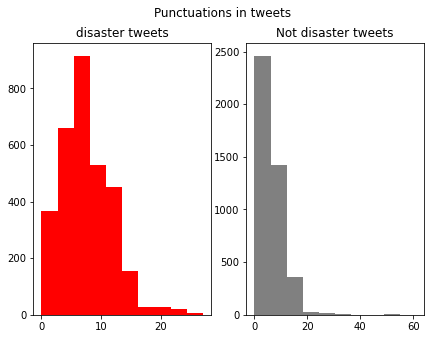

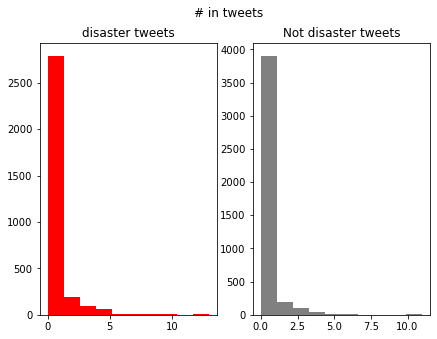

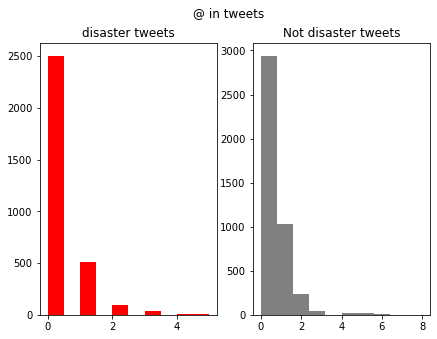

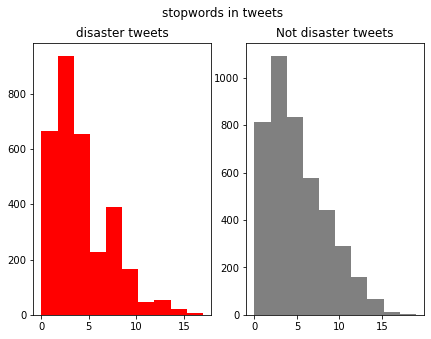

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(7,5))
tweet_len=train[train['target']==1]['word_count']
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['word_count']
ax2.hist(tweet_len,color='grey')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in tweets')

fig,(ax3,ax4)=plt.subplots(1,2,figsize=(7,5))
tweet_len=train[train['target']==1]['char_count']
ax3.hist(tweet_len,color='red')
ax3.set_title('disaster tweets')
tweet_len=train[train['target']==0]['char_count']
ax4.hist(tweet_len,color='grey')
ax4.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')

fig,(ax5,ax6)=plt.subplots(1,2,figsize=(7,5))
tweet_len=train[train['target']==1]['mean_word_length']
ax5.hist(tweet_len,color='red')
ax5.set_title('disaster tweets')
tweet_len=train[train['target']==0]['mean_word_length']
ax6.hist(tweet_len,color='grey')
ax6.set_title('Not disaster tweets')
fig.suptitle('Word length in tweets')

fig,(ax7,ax8)=plt.subplots(1,2,figsize=(7,5))
tweet_len=train[train['target']==1]['link_count']
ax7.hist(tweet_len,color='red')
ax7.set_title('disaster tweets')
tweet_len=train[train['target']==0]['link_count']
ax8.hist(tweet_len,color='grey')
ax8.set_title('Not disaster tweets')
fig.suptitle('Links in tweets')

fig,(ax9,ax10)=plt.subplots(1,2,figsize=(7,5))
tweet_len=train[train['target']==1]['punctuation_count']
ax9.hist(tweet_len,color='red')
ax9.set_title('disaster tweets')
tweet_len=train[train['target']==0]['punctuation_count']
ax10.hist(tweet_len,color='grey')
ax10.set_title('Not disaster tweets')
fig.suptitle('Punctuations in tweets')

fig,(ax11,ax12)=plt.subplots(1,2,figsize=(7,5))
tweet_len=train[train['target']==1]['hashtag_count']
ax11.hist(tweet_len,color='red')
ax11.set_title('disaster tweets')
tweet_len=train[train['target']==0]['hashtag_count']
ax12.hist(tweet_len,color='grey')
ax12.set_title('Not disaster tweets')
fig.suptitle('# in tweets')

fig,(ax13,ax14)=plt.subplots(1,2,figsize=(7,5))
tweet_len=train[train['target']==1]['at_count']
ax13.hist(tweet_len,color='red')
ax13.set_title('disaster tweets')
tweet_len=train[train['target']==0]['at_count']
ax14.hist(tweet_len,color='grey')
ax14.set_title('Not disaster tweets')
fig.suptitle('@ in tweets')

fig,(ax15,ax16)=plt.subplots(1,2,figsize=(7,5))
tweet_len=train[train['target']==1]['stopword_count']
ax15.hist(tweet_len,color='red')
ax15.set_title('disaster tweets')
tweet_len=train[train['target']==0]['stopword_count']
ax16.hist(tweet_len,color='grey')
ax16.set_title('Not disaster tweets')
fig.suptitle('stopwords in tweets')

plt.show()

**Interpretation** <br>
Due to the fact that not disaster Tweets tend to be a bit longer, it is not surprising that stop words are used more often. However, the number of characters does not differ significantly, only very long tweets of 150 characters are increasingly classified as disaster. 
Regarding the use of links, disaster tweets show 1-2 links more often, the use of @ differs less. disaster tweets show a higher use of punctuations, but outliners are rather not disasters. 




## **Cleaning** <br>
**Preparation for the models:** <br>
Punctuation marks, links and stop words are not considered for the following models. These would possibly falsify the model, but have little effect on the content and are therefore of little relevance for the classification. 

In [ ]:
train.head(2)

,keyword,location,text,target,word_count,char_count,unique_word_count,link_count,mean_word_length,punctuation_count,hashtag_count,at_count,stopword_count,keyword_target_mean
id,,,,,,,,,,,,,,
1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,69,13,0,4.384615,1,1,0,6,0.660714
4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,38,7,0,4.571429,1,0,0,0,0.660714


In [ ]:
def StopWordCleanser(word):
    if word in stopwords.words('english'):
        return ""
    else:
        return word

def clean_data(x):
  x = re.sub('https?://\S+|www\.\S+', '', x)
  x = re.sub("'", " ", x)
  x = re.sub(r"&gt;", "", x)
  x = re.sub(r"&lt;", "", x)
  x = re.sub(r"&amp;", "", x)
  x = re.sub(r"\n", " ", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"åê", "", x)
  x = re.sub(r"\x89ûï", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"\x89ûò", "", x)
  x = re.sub(r"\x89ûª", "", x)
  x = re.sub(r"\x89û", "", x)
  x = re.sub(r"\x9d", "", x)
  x = re.sub('\w*\d\w*', '', x)
  x = re.sub('ì©', 'é', x)
  x = re.sub("[@.!?\\-*#+_:,;=><'§$%&/°^`´{}>|~()]", "",x)
  return x

#remove stopswords
train['text'] = train['text'].apply(lambda x: " ".join([StopWordCleanser(i) for i in str(x).split()]))
test['text'] = test['text'].apply(lambda x: " ".join([StopWordCleanser(i) for i in str(x).split()]))

#remove URLs
train['text'] = train['text'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x)))
train['text'] = train['text'].apply(lambda x: re.sub(r'http?:\/\/t.co\/[A-Za-z0-9]+', '', str(x)))
test['text'] = test['text'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x)))
test['text'] = test['text'].apply(lambda x: re.sub(r'http?:\/\/t.co\/[A-Za-z0-9]+', '', str(x)))

#remove #
train['text'] = train['text'].apply(lambda x: re.sub(r'#', '', str(x)))
test['text'] = test['text'].apply(lambda x: re.sub(r'#', '', str(x)))

#remove punctuation
train['text'] = train['text'].apply(lambda x: str(x).translate(str.maketrans('','',string.punctuation)))
test['text'] = test['text'].apply(lambda x: str(x).translate(str.maketrans('','',string.punctuation)))

#convert all the words into lower case
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()

#clean data
train['text']=train['text'].apply(lambda x: clean_data(x))
test['text']=test['text'].apply(lambda x: clean_data(x))

train.head(5) #check if all removements worked


,keyword,location,text,target,word_count,char_count,unique_word_count,link_count,mean_word_length,punctuation_count,hashtag_count,at_count,stopword_count,keyword_target_mean
id,,,,,,,,,,,,,,
1,no_keyword,no_location,our deeds are the reason of this earthquake ma...,1,13,69,13,0,4.384615,1,1,0,6,0.660714
4,no_keyword,no_location,forest fire near la ronge sask canada,1,7,38,7,0,4.571429,1,0,0,0,0.660714
5,no_keyword,no_location,all residents asked to shelter in place are be...,1,22,133,20,0,5.090909,3,0,0,11,0.660714
6,no_keyword,no_location,people receive wildfires evacuation orders in...,1,8,65,8,0,7.125000,2,1,0,1,0.660714
7,no_keyword,no_location,just got sent this photo from ruby alaska as s...,1,16,88,15,0,4.500000,2,2,0,7,0.660714


## **Models** <br>
In the following steps we will take a look 5 different models, in order to find out, which way of prediction is the best:


1.  **Jaccard Similarity based on the idea of a recommender system** <br>
In this approach, the similarity of the sentences is the basis for the model. The definition is as follows: <br>
  *Jaccard similarity or intersection over union is defined as size of intersection divided by size of union of two sets.* <br>
However, in this case it is important to know that multiple use of words within a sentence has no effect. (e.g. Jaccard similarity does not distinguish between the sentences "The house is green" and "The house is house is green") 
The approach can be simplified in Python as below: 
```
def jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c)

    set() splits the sentence into the alphabet:
        set('string')
  --> set(['g', 'i', 'n', 's', 'r', 't'])
```
2.   **Levenshtein Similarity based on the idea of a recommender system** <br>
The Levenshtein distance (also called edit distance) between two strings is the minimum number of insert, delete and replace operations to convert the first string to the second. <br>
For example, the Levenshtein distance between "Tier" and "Tor" is 2. A possible consequence of two operations is:

  *   Tier
  *   Toer (Replace i with o)
  *   Tor (Delete e)

  A central point of this model is the consideration of the number of characters. This can be an advantage or disadvantage in the application. However, due to the character limit of 150 per tweet, it seems to be a workable approach.
  Based on a created distance matrix between the tweets it is possible to show the similarity between statements. The test data can be added to this matrix. For each test tweet the train tweet with the smallest distance is determined and a classification is deduced.

3.   **Logistic Regression** <br>
4.   **Word2Vev** <br>
Word2vec is a two-layer neural network for word processing. It "vectorizes" words, making natural language computer readable.
The goal of Word2vec is to merge vectors of similar words in vector space, so it recognizes the context, without human help.  A well-trained set of word vectors places similar words close together in this space. The words oak, elm, and birch could be grouped together in one corner, while war, conflict, and strife could merge in another.


5.   **BERT (Bidirectional Encoder Representations from Transformers)**<br>

  BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. In its vanilla form, Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task. Since BERT’s goal is to generate a language model, only the encoder mechanism is necessary.
  A particular feature of this approach is that BERT also pays attention to the word order. 
Thus, the complete context of words can be assessed by also considering the words before and after another word. In this way, the intention of complex texts or tweets can be better determined. (https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)



In [ ]:
#Use a subset of train in order to show how this approaches are working
train_sub={'text': train['text'][0:100]}
data = pd.DataFrame(train_sub)

## **1. Jaccard Similarity**

In [ ]:
#This would be a custom definition, but it is already included as part of nltk (but just for numeric values)
def jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


In [ ]:
#example to show how the model basically works

w1 = set("An earthquake shocks Japan")
w2 = set("The victory of the team resembled an earthquake")
 
nltk.jaccard_distance(w1, w2)

0.48

In [ ]:
from scipy.spatial.distance import pdist, squareform

# my list of strings
strings_jacc = data['text']

# prepare 2 dimensional array M x N (M entries (3) with N dimensions (1)) 
transformed_strings_jacc = np.array(strings_jacc).reshape(-1,1)

# calculate condensed distance matrix by wrapping the Levenshtein distance function
distance_matrix_jacc = pdist(transformed_strings_jacc,lambda x,y: jaccard_sim(x[0],y[0]))

# get square matrix
sq_distance_matrix_jacc=squareform(distance_matrix_jacc)

#Modify the main diagonal of the matrix
np.fill_diagonal(sq_distance_matrix_jacc, 0)

print(sq_distance_matrix_jacc)

[[0.         0.         0.06896552 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.06896552 0.         0.         ... 0.03846154 0.03030303 0.0625    ]
 ...
 [0.         0.         0.03846154 ... 0.         0.04166667 0.08695652]
 [0.         0.         0.03030303 ... 0.04166667 0.         0.18518519]
 [0.         0.         0.0625     ... 0.08695652 0.18518519 0.        ]]


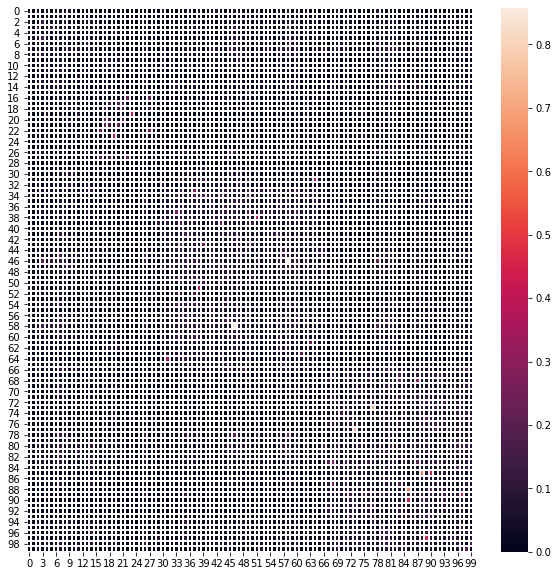

In [ ]:
# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    sq_distance_matrix_jacc,
    cmap='rocket',
    linewidth=1
)

In [ ]:
print('Avarage distance: ' + str(np.average(sq_distance_matrix_jacc)))
print('Min distance: ' + str(np.min(sq_distance_matrix_jacc)))
print('Max distance: ' + str(np.max(sq_distance_matrix_jacc)))

Avarage distance: 0.026217303906703973
Min distance: 0.0
Max distance: 0.8571428571428571


Since the average distance is so small, it is not worth pursuing this approach further.

## **2. Levenshtein distance**

In [ ]:
from Levenshtein import distance
from scipy.spatial.distance import pdist, squareform

# my list of strings
strings = data['text']

# prepare 2 dimensional array M x N (M entries (3) with N dimensions (1)) 
transformed_strings = np.array(strings).reshape(-1,1)

# calculate condensed distance matrix by wrapping the Levenshtein distance function
distance_matrix = pdist(transformed_strings,lambda x,y: distance(x[0],y[0]))

# get square matrix
sq_distance_matrix=squareform(distance_matrix)
print(sq_distance_matrix)


[[  0.  52.  96. ...  51.  67.  73.]
 [ 52.   0. 104. ...  35.  72.  80.]
 [ 96. 104.   0. ...  99.  95.  97.]
 ...
 [ 51.  35.  99. ...   0.  68.  73.]
 [ 67.  72.  95. ...  68.   0.  72.]
 [ 73.  80.  97. ...  73.  72.   0.]]


In [ ]:
#Modify the main diagonal of the matrix
np.fill_diagonal(sq_distance_matrix, 200)

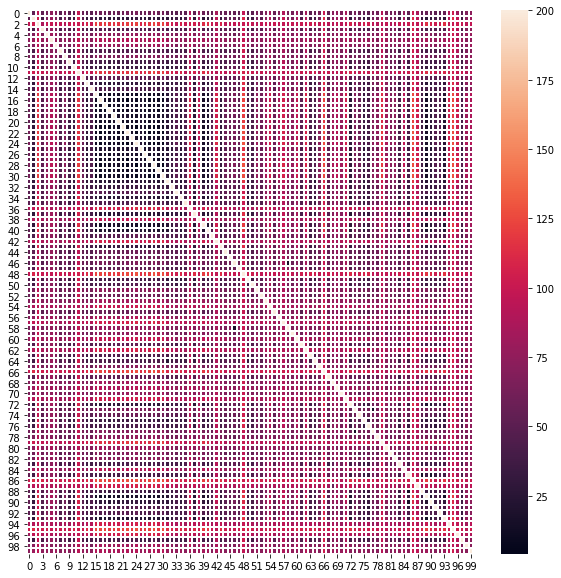

In [ ]:
# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    sq_distance_matrix,
    cmap='rocket',
    linewidth=1
)

In [ ]:
#Check if this approach works with an example
print(train['text'][15] + " " + str(train['target'][15]))
print(train['text'][18] + " " + str(train['target'][18]))

print("Those two sentences got a distance of "+ str(distance(train['text'][15],train['text'][18])))

im afraid that the tornado is coming to our area 1
raining flooding florida tampabay tampa  or  days ive lost count  1
Those two sentences got a distance of 50


Looks very good at first glance, but both tweets are very short, or it could also be pure coincidence. <br>
Therefore it is necessary to check the entire data.

In [ ]:
print('Avarage distance: ' + str(np.average(sq_distance_matrix)))
print('Min distance: ' + str(np.min(sq_distance_matrix)))
print('Max distance: ' + str(np.max(sq_distance_matrix)))

Avarage distance: 70.1346
Min distance: 4.0
Max distance: 200.0


In [ ]:
#Since the maximum number of characters is 150, this offers a possibility to check whether it is worthwhile to continue this approach.
print("The Matrix got " +  str(len(sq_distance_matrix)**2) + " elements")
print("The avarage length of a tweet is " + str(int(train['char_count'].mean())) + " characters")
print(str(np.sum(sq_distance_matrix>=50)) + " of them got a value over 50")

The Matrix got 10000 elements
The avarage length of a tweet is 100 characters
7506 of them got a value over 50


Since only about 1/4 of the test data show a distance of less than 50, this approach will not be pursued further. The similarity according to Levenshtein distance is not sufficient to draw conclusions about the classification. If this approach would have shown a smaller avarage distance, you could proceed similar to a recommender system. Each tweet from the test data would be added to the matrix. The tweet of the training data with the smallest distance is then determined and the classification is deduced from this.

## **3. Logistic Regression**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

#split into train and test
X_train,X_test,y_train,y_test = train_test_split(train['text'],train['target'])
vector = TfidfVectorizer().fit(X_train)

#vektorize the tweets
X_train_vector = vector.transform(X_train)
X_test_vector = vector.transform(X_test)

In [ ]:
score_df = pd.DataFrame(columns={'Model Description','Score'})

model = LogisticRegression().fit(X_train_vector,y_train)
print('Logistic Regression with TFIDF - ' + str((roc_auc_score(y_test,model.predict(X_test_vector)))))
print('F1Score - ' + str((f1_score(y_test,model.predict(X_test_vector)))))

Logistic Regression with TFIDF - 0.7811415435047033
F1Score - 0.7380125086865879


A score or 0.7811 is a really good result for such a simple model.

## **4. Word2Vec**

In [ ]:
#tokenize the tweets
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text_tokenized'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text_tokenized'] = test['text'].apply(lambda x: tokenizer.tokenize(x))
train.head(3)

,keyword,location,text,target,word_count,char_count,unique_word_count,link_count,mean_word_length,punctuation_count,hashtag_count,at_count,stopword_count,keyword_target_mean,text_tokenized
id,,,,,,,,,,,,,,,
1,no_keyword,no_location,our deeds are the reason of this earthquake ma...,1,13,69,13,0,4.384615,1,1,0,6,0.660714,"[our, deeds, are, the, reason, of, this, earth..."
4,no_keyword,no_location,forest fire near la ronge sask canada,1,7,38,7,0,4.571429,1,0,0,0,0.660714,"[forest, fire, near, la, ronge, sask, canada]"
5,no_keyword,no_location,all residents asked to shelter in place are be...,1,22,133,20,0,5.090909,3,0,0,11,0.660714,"[all, residents, asked, to, shelter, in, place..."


In [ ]:
#importing a pretrained word2vec model in order to get better results
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin', binary=True)
#path = '../input/googles-trained-word2vec-model-in-python'
#model = gensim.models.KeyedVectors.load_word2vec_format(path,binary=True)

In [ ]:
#let's try the functionality with one of the top disaster keywords, maybe some other keywords show up
model.similar_by_word('outbreak', topn=5)

[('outbreaks', 0.8043085932731628),
 ('bird_flu_outbreak', 0.6895532608032227),
 ('flu_outbreak', 0.6868605613708496),
 ('avian_flu_outbreak', 0.6808136105537415),
 ('avian_influenza_outbreak', 0.6709142923355103)]

In [ ]:
#create a list corpus which we would be using to train word2vec mappings
def fn_pre_process_data(doc):
    for rec in doc:
        yield gensim.utils.simple_preprocess(rec)

corpus = list(fn_pre_process_data(train['text']))
corpus += list(fn_pre_process_data(test['text']))

In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(corpus,size=150,window=3,min_count=2)
w2v_model.train(corpus,total_examples=len(corpus),epochs=10)

(1092068, 1394400)

In [ ]:
def get_word_embeddings(token_list,vector,k=150):
    if len(token_list) < 1:
        return np.zeros(k)
    else:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in token_list] 
    
    sum = np.sum(vectorized,axis=0)
    ## return the average
    return sum/len(vectorized)        
def get_embeddings(tokens,vector):
        embeddings = tokens.apply(lambda x: get_word_embeddings(x, w2v_model))
        return list(embeddings)

train_embeddings = get_embeddings(train['text_tokenized'],w2v_model)
test_embeddings = get_embeddings(test['text_tokenized'],w2v_model)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Let's start applying learning models.

We will start by applying Logisitic Regression to get a baseline by using Gridsearch to get the best combination of parameters for Logisitic Regression.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_model = LogisticRegression()
grid_values ={'penalty':['l1','l2'],'C':[0.0001,0.001,0.01,0.1,1,10]}
grid_search_model = GridSearchCV(lr_model,param_grid=grid_values,cv=3)
grid_search_model.fit(train_embeddings,train['target'])
print(grid_search_model.best_estimator_)
print(grid_search_model.best_score_)
print(grid_search_model.best_params_)

predict_lr = grid_search_model.predict(test_embeddings)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

LogisticRegression(C=1)
0.7337357478202549
{'C': 1, 'penalty': 'l2'}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Now let's use Random Forrest in order to get the results for Word2Vec

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestClassifier()
grid_values ={'n_estimators':[10,50,100,150,200,300,400]}

grid_search_model = GridSearchCV(rf_model,param_grid=grid_values,cv=4)
grid_search_model.fit(train_embeddings,train['target'])
print(grid_search_model.best_estimator_)
print(grid_search_model.best_score_)
print(grid_search_model.best_params_)

predict_rf = grid_search_model.predict(test_embeddings)

RandomForestClassifier(n_estimators=300)
0.7340065114875403
{'n_estimators': 300}


0.7340 is a worse result then i thought, but maybe BERT is a better way to solve this classification problem

## **5. BERT**

In [ ]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
import tokenization

In [ ]:
#Version 15
model_type = 'default'
Dropout_num = 0
learning_rate = 1e-5
max_len = 160
layers = [] #not including final layer
activation = 'relu' #for the non-final layers
epochs=3
batch_size=16
validation_split=0.2

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"] #CLS and SEP are important in order to show BERT the first position [CLS] and [SEP] at the end of the sentence
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    add_input = Input(shape=(ADD_DIM,), dtype=tf.float32, name='add_input')

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if model_type=='default':
        # Without Dropout
        for layer in layers:
            clf_output = Dense(layer, activation=activation)(clf_output)
            clf_output = Concatenate()([clf_output, add_input])
        out = Dense(1, activation='sigmoid')(clf_output)
    elif model_type=='dropout':
        # With Dropout(Dropout_num), Dropout_num > 0
        for layer in layers:
            x = Dropout(Dropout_num)(clf_output)
            clf_output = Dense(layer, activation=activation)(x)
            x = Concatenate()([x, add_input])
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)
    elif model_type=='GlobalAveragePooling1D':
        for layer in layers:
            if Dropout_num>0:
                clf_output = Dropout(Dropout_num)(clf_output)
                clf_output = Concatenate()([clf_output, add_input])
            clf_output = Dense(layer, activation=activation)(clf_output)
        x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids, add_input], outputs=out)
    opt = tf.keras.optimizers.Adam(lr=learning_rate)
    opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 27.9 s, sys: 4.82 s, total: 32.7 s
Wall time: 48.6 s


In [ ]:
FullTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(train.text.values, tokenizer, max_len=max_len)
test_input = bert_encode(test.text.values, tokenizer, max_len=max_len)
train_labels = train.target.values

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
checkpoint =  tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

history=model.fit(
    [train_input, train_add_input], train_labels,
    validation_split=validation_split,
    epochs=epochs,
    callbacks=[checkpoint],
    batch_size=batch_size,
)

Epoch 1/3
373/373 [==============================] - 401s 1s/step - loss: 0.4300 - accuracy: 0.8115 - val_loss: 0.3945 - val_accuracy: 0.8236
Epoch 2/3
373/373 [==============================] - 366s 980ms/step - loss: 0.2566 - accuracy: 0.8996 - val_loss: 0.4145 - val_accuracy: 0.8397
Epoch 3/3
373/373 [==============================] - 366s 980ms/step - loss: 0.1146 - accuracy: 0.9579 - val_loss: 0.5156 - val_accuracy: 0.8323


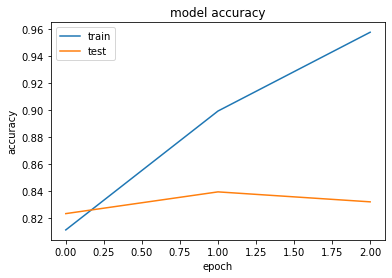

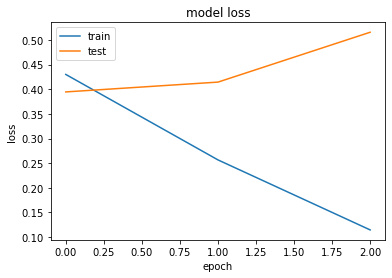

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Here are some models and their scores with regard to hyperparameter optimization:

1.Attempt Kaggle-Score: 0.83021 <br>
* 4 epochs
* 0,2 validation split
* 16 batch size
* 1e-5 learning rate 
* 0.2 dropout
* with meta_information_layer

2.Attempt Score: 0.82102 <br>
* 6 epochs,
* Validation Split 0.3,
* batch size 16,
* learning_rate 0.0000001,
* dropout 0.1,
* without meta_information_layer

3.Attempt Score: 0.80386 <br>
* 7 epochs,
* Validation Split 0.3,
* batch size 32,
* learning_rate 0.0000005
* dropout 0.1,
* without meta_information_layer

4.Attempt Score: 0.83910 <br>
* 3 epochs,
* Validation Split 0.2,
* batch size 16,
* learning_rate 0.0000005
* no dropout
* with meta_information_layer
* changed BERT-Dataset to https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1
* changed tokenizer

Attempt 4 got the best result with an accuracy of 0.84492%


In [ ]:
model.load_weights('model.h5')
test_pred = model.predict([test_input])

In [ ]:
sub_sample['target'] = test_pred.round().astype(int)
sub_sample.to_csv('submission.csv', index=False)

In [ ]:
sub_sample.shape

(3263, 2)

Useful Notebooks:


*   https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub
*   https://www.kaggle.com/parthplc/word2vec-tutorial
*   https://www.kaggle.com/joswin/bert-try#BERT-Model

